<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/walk-thru/04_mnist_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Full Dataset
Model to classify MNIST for unpackAI Bootcamp 2: first session

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 19.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 49.1MB/s 
     |████████████████████████████████| 1.1MB 54.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Load MNIST data and create dataloaders

In [4]:
path = untar_data(URLs.MNIST)
path.ls(),  (path/'training').ls(), (path/'testing').ls()

((#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')],
 (#10) [Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/4')],
 (#10) [Path('/root/.fastai/data/mnist_png/testing/3'),Path('/root/.fastai/data/mnist_png/testing/1'),Path('/root/.fastai/data/mnist_png/testing/0'),Path('/root/.fastai/data/mnist_png/testing/9'),Path('/root/.fastai/data/mnist_png/testing/6'),Path('/root/.fastai/data/mnist_png/testing/2'),Path('/root/.fastai/data/mnist_png/testing/8'),Path('/root/.fastai/data/mnist_png/testing/5'),Path('/root/.fastai/data/m

Folder structure: 
- `training\0`: all images of 0
- `training\1`: all images of 1
- . . . 
- `training\9`: all images of 9
- `testing\0`: all images of 0
- `testing\1`: all images of 1
- . . . 
- `testing\9`: all images of 9

Elements to create the DataBlocks:
- `blocks`: 
    - `ImageBlock`. But MNIST images are BW, so we also pass the cls `PILImageBW`
    - `CategoryBlock`
- `get_items`: `get_image_files` method to get the list of all image files in the folder
- `get_y`: `parent_label` as images are grouped be folder/category
- `splitter`: `RamdomSplitter` because this dataset only includes a training folder and a testing folder, no validation folder.

Augmentation: exclude flipping and cropping

In [51]:
rotation = Rotate(max_deg=30, p=0.5, draw=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False)

augmentation = aug_transforms(mult=1.0, 
                              do_flip=False, 
                              flip_vert=False, 
                              max_rotate=15.0, 
                              min_zoom=0.50, 
                              max_zoom=1.0, 
                              max_lighting=0.3, 
                              max_warp=0, 
                              p_affine=0.75, 
                              p_lighting=0.75, 
                              xtra_tfms=None, 
                              size=None, 
                              mode='bilinear',
                            #   mode='nearest',
                              pad_mode='border', # {'zeros': 'constant', 'border': 'edge', 'reflection': 'reflect'}
                              align_corners=True, 
                              batch=False, 
                              min_scale=1.0)

In [52]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(seed=1988),
                   batch_tfms=augmentation
                   )

In [53]:
dls = dblock.dataloaders(path/'training', bs=256)

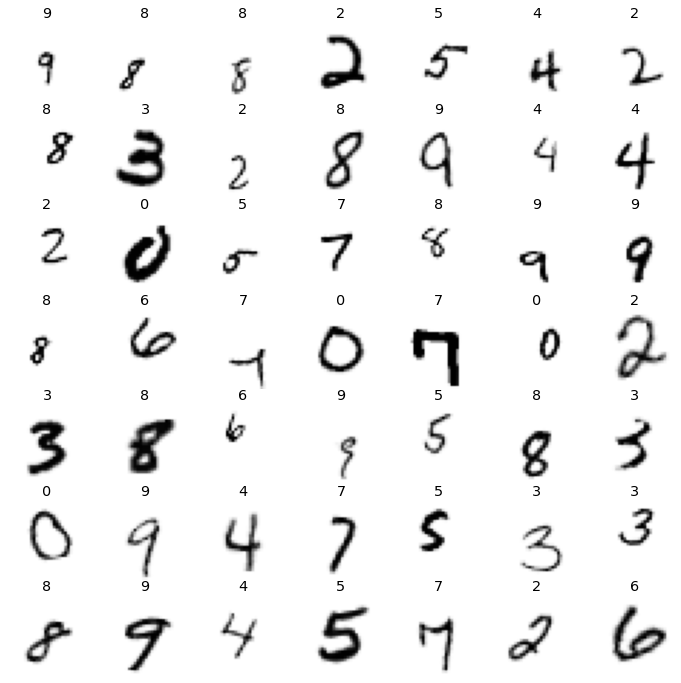

In [54]:
dls.show_batch(max_n=49, figsize=(12,12))

In [37]:
dls.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# dblock.summary(path)

## Define Testset dataloader and metrics

In [55]:
test_dls = dblock.dataloaders(path/'testing')
test_dl = dls.test_dl(test_items=test_dls.items, with_labels=True)

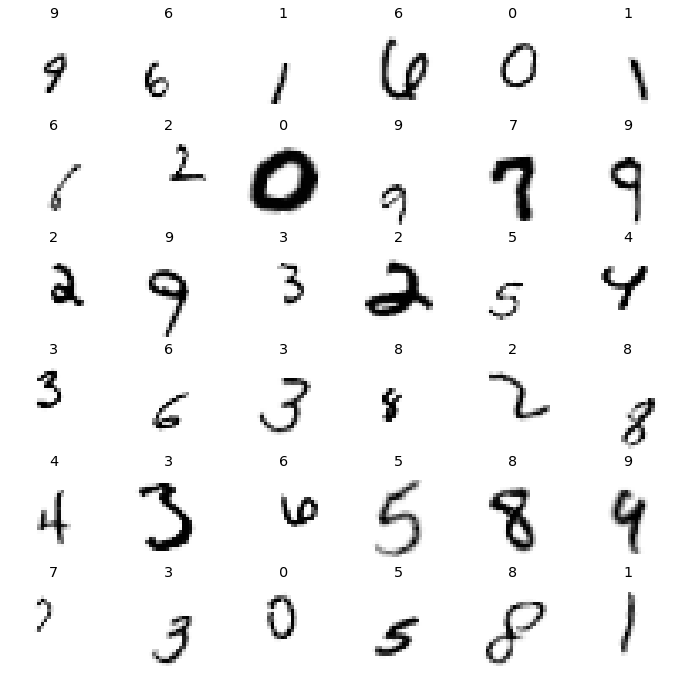

In [56]:
test_dls.show_batch(max_n=36, figsize=(12,12))

In [57]:
precision = Precision(average='macro')
recall = Recall(average='macro')

## Resnet 18  Pretrained

In [24]:
learn_18 = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy, precision, recall], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.007585775572806597)

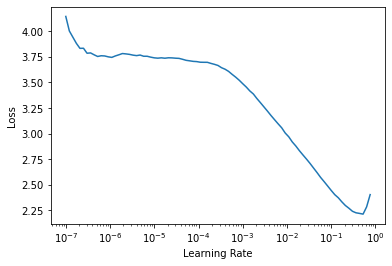

In [25]:
learn_18.lr_find()

In [26]:
n = 8
lr = 1e-2
learn_18.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.587803,0.225222,0.067833,0.932167,0.933957,0.931498,00:55
1,0.215280,0.133776,0.037417,0.962583,0.963282,0.962333,00:55
2,0.147358,0.070805,0.019083,0.980917,0.981004,0.980624,00:54
3,0.114209,0.081954,0.024250,0.975750,0.976173,0.975395,00:55
4,0.099834,0.061050,0.017833,0.982167,0.982320,0.981888,00:55
5,0.078227,0.040146,0.012167,0.987833,0.987872,0.987725,00:55
6,0.065872,0.042966,0.013667,0.986333,0.986462,0.986288,00:54
7,0.060254,0.038855,0.012833,0.987167,0.987279,0.987026,00:55


Results for dataloader without augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.409579   | 0.171444   | 0.051917   | 0.948083 | 0.947772        | 0.947966     | 00:52 |
| 1     | 0.138568   | 0.140069   | 0.040583   | 0.959417 | 0.960020        | 0.959577     | 00:51 |
| 2     | 0.093107   | 0.151755   | 0.041333   | 0.958667 | 0.959541        | 0.959296     | 00:50 |
| 3     | 0.070350   | 0.068100   | 0.017750   | 0.982250 | 0.982272        | 0.982171     | 00:50 |
| 4     | 0.053668   | 0.054839   | 0.014417   | 0.985583 | 0.985631        | 0.985578     | 00:49 |
| 5     | 0.035598   | 0.040150   | 0.010917   | 0.989083 | 0.989159        | 0.989073     | 00:49 |
| 6     | 0.025495   | 0.040677   | 0.010167   | 0.989833 | 0.989855        | 0.989753     | 00:49 |
| 7     | 0.015215   | 0.040784   | 0.009500   | 0.990500 | 0.990497        | 0.990430     | 00:50 |

Results for dataloader with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.281269   | 0.156072   | 0.046917   | 0.953083 | 0.954461        | 0.952646     | 00:51 |
| 1     | 0.112043   | 0.075744   | 0.022583   | 0.977417 | 0.977428        | 0.976989     | 00:51 |
| 2     | 0.078653   | 0.052826   | 0.014917   | 0.985083 | 0.985192        | 0.984778     | 00:51 |
| 3     | 0.060607   | 0.056665   | 0.015250   | 0.984750 | 0.985066        | 0.984336     | 00:51 |
| 4     | 0.042045   | 0.054098   | 0.015417   | 0.984583 | 0.984736        | 0.984505     | 00:51 |
| 5     | 0.027003   | 0.040291   | 0.010500   | 0.989500 | 0.989536        | 0.989372     | 00:51 |
| 6     | 0.011142   | 0.029470   | 0.007417   | 0.992583 | 0.992556        | 0.992548     | 00:51 |
| 7     | 0.005596   | 0.028730   | 0.007167   | 0.992833 | 0.992806        | 0.992759     | 00:51 |

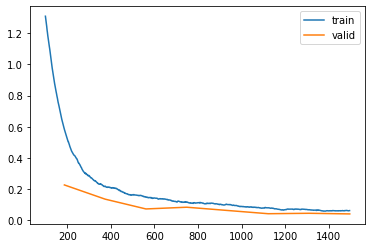

In [27]:
learn_18.recorder.plot_loss(skip_start=100)

In [28]:
learn_18.validate(dl=test_dl)

(#5) [0.029335234314203262,0.00912499986588955,0.9908750057220459,0.9908797154533575,0.9908350920223237]

With no augmentation

| Metric | Value |
|--------|-----:|
| Error Rate | 0.008125 |
| Accuracy |0.991875|
| Precision | 0.991881|
| Recall | 0.991857|

With augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.009125
| Accuracy | 0.990875
| Precision | 0.990880
| Recall | 0.990835

## Resnet 18  Untrained

In [29]:
learn_18_unt = cnn_learner(dls, 
                           resnet18, metrics=[error_rate, accuracy, precision, recall], 
                           pretrained=False
                           )

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0020892962347716093)

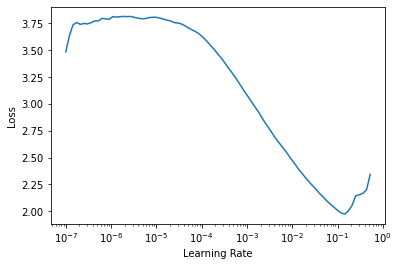

In [30]:
learn_18_unt.lr_find()

In [31]:
n = 8
lr = 2e-3
learn_18_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.451950,0.293534,0.070167,0.929833,0.934617,0.930077,00:56
1,0.209920,0.157511,0.046417,0.953583,0.955947,0.953505,00:56
2,0.141694,0.171997,0.044833,0.955167,0.958470,0.954816,00:56
3,0.115787,0.105908,0.030500,0.969500,0.970300,0.969616,00:56
4,0.092771,0.051511,0.014583,0.985417,0.985440,0.985379,00:56
5,0.061399,0.037154,0.010917,0.989083,0.989066,0.989119,00:57
6,0.044307,0.026106,0.006750,0.993250,0.993149,0.993251,00:56
7,0.030072,0.023031,0.006000,0.994000,0.993958,0.993945,00:56


Results without augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.281269   | 0.156072   | 0.046917   | 0.953083 | 0.954461        | 0.952646     | 00:51 |
| 1     | 0.112043   | 0.075744   | 0.022583   | 0.977417 | 0.977428        | 0.976989     | 00:51 |
| 2     | 0.078653   | 0.052826   | 0.014917   | 0.985083 | 0.985192        | 0.984778     | 00:51 |
| 3     | 0.060607   | 0.056665   | 0.015250   | 0.984750 | 0.985066        | 0.984336     | 00:51 |
| 4     | 0.042045   | 0.054098   | 0.015417   | 0.984583 | 0.984736        | 0.984505     | 00:51 |
| 5     | 0.027003   | 0.040291   | 0.010500   | 0.989500 | 0.989536        | 0.989372     | 00:51 |
| 6     | 0.011142   | 0.029470   | 0.007417   | 0.992583 | 0.992556        | 0.992548     | 00:51 |
| 7     | 0.005596   | 0.028730   | 0.007167   | 0.992833 | 0.992806        | 0.992759     | 00:51 |

Results with augmentation

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.451950   | 0.293534   | 0.070167   | 0.929833 | 0.934617        | 0.930077     | 00:56 |
| 1     | 0.209920   | 0.157511   | 0.046417   | 0.953583 | 0.955947        | 0.953505     | 00:56 |
| 2     | 0.141694   | 0.171997   | 0.044833   | 0.955167 | 0.958470        | 0.954816     | 00:56 |
| 3     | 0.115787   | 0.105908   | 0.030500   | 0.969500 | 0.970300        | 0.969616     | 00:56 |
| 4     | 0.092771   | 0.051511   | 0.014583   | 0.985417 | 0.985440        | 0.985379     | 00:56 |
| 5     | 0.061399   | 0.037154   | 0.010917   | 0.989083 | 0.989066        | 0.989119     | 00:57 |
| 6     | 0.044307   | 0.026106   | 0.006750   | 0.993250 | 0.993149        | 0.993251     | 00:56 |
| 7     | 0.030072   | 0.023031   | 0.006000   | 0.994000 | 0.993958        | 0.993945     | 00:56 |

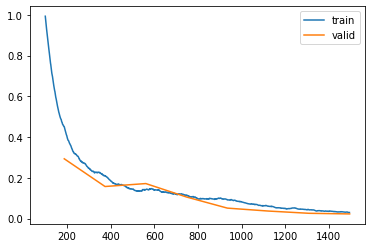

In [32]:
learn_18_unt.recorder.plot_loss(skip_start=100)

In [33]:
learn_18_unt.validate(dl=test_dl)

(#5) [0.01865571364760399,0.005874999798834324,0.9941250085830688,0.9941249993639486,0.9940353536788195]

Without augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.0067500
| Accuracy | 0.9932500
| Precision | 0.9932891
| Recall | 0.9931777

With augmentation:

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00587500
| Accuracy | 0.99412501
| Precision | 0.99412500
| Recall | 0.99403535

## Resnet 34 Pretrained

In [ ]:
learn_34 = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy, precision, recall], pretrained=True)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.013182567432522774)

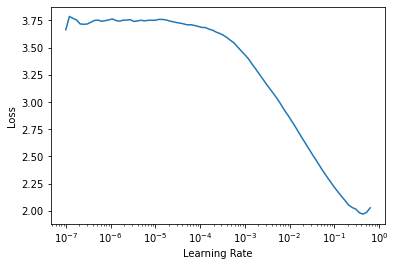

In [ ]:
learn_34.lr_find()

In [ ]:
n = 8
lr = 1e-2
learn_34.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.368139,0.167955,0.050250,0.949750,0.950084,0.949740,00:56
1,0.127198,0.129974,0.037500,0.962500,0.964245,0.961122,00:55
2,0.089532,0.125045,0.034750,0.965250,0.966986,0.964015,00:56
3,0.068741,0.072835,0.021833,0.978167,0.978542,0.978169,00:55
4,0.048072,0.049588,0.013083,0.986917,0.987393,0.986802,00:56
5,0.031072,0.038731,0.009083,0.990917,0.991010,0.990727,00:56
6,0.017881,0.031832,0.007750,0.992250,0.992271,0.992135,00:56
7,0.011673,0.030884,0.007167,0.992833,0.992831,0.992728,00:55


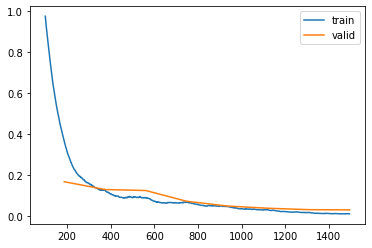

In [ ]:
learn_34.recorder.plot_loss(skip_start=100)

In [ ]:
learn_34.validate(dl=test_dl)

(#5) [0.021880125626921654,0.00787500012665987,0.9921249747276306,0.9921124563875956,0.9920476920599901]

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00787500
| Accuracy | 0.99212497
| Precision | 0.99211246
| Recall | 0.99204769

In [ ]:
learn_34.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=3.981071586167673e-06)

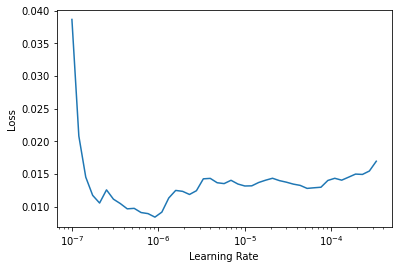

In [ ]:
learn_34.lr_find()

In [ ]:
n = 10
lr = 5e-7
learn_34.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.009512,0.030438,0.006917,0.993083,0.993099,0.992969,01:00
1,0.009969,0.030400,0.007333,0.992667,0.992706,0.992521,00:58
2,0.010843,0.030063,0.006833,0.993167,0.993175,0.993063,00:59
3,0.009818,0.030025,0.007000,0.993000,0.993010,0.992887,00:59
4,0.008848,0.030471,0.007083,0.992917,0.992932,0.992816,00:59
5,0.008581,0.030649,0.007250,0.992750,0.992786,0.992606,00:58
6,0.008628,0.030191,0.007250,0.992750,0.992784,0.992632,00:59
7,0.008571,0.030379,0.006833,0.993167,0.993189,0.993030,00:59
8,0.007604,0.030400,0.007083,0.992917,0.992955,0.992764,00:59
9,0.009241,0.030837,0.006917,0.993083,0.993147,0.992917,00:58


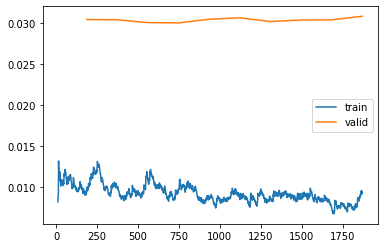

In [ ]:
learn_34.recorder.plot_loss(skip_start=10)

In [ ]:
learn_34.validate(dl=test_dl)

(#5) [0.020970115438103676,0.007249999791383743,0.9927499890327454,0.992786805523178,0.9926656570580338]

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00787500
| Accuracy | 0.99212497
| Precision | 0.99211246
| Recall | 0.99204769

## Resnet 34 Untrained

In [56]:
learn_34_unt = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy, precision, recall], pretrained=False)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0030199517495930195)

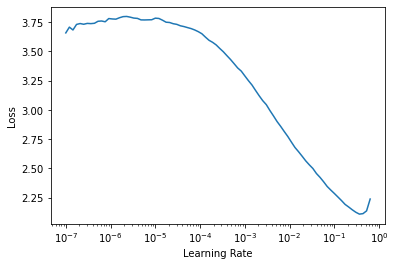

In [41]:
learn_34_unt.lr_find()

In [42]:
n = 12
lr = 5e-3
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.434923,0.204655,0.056417,0.943583,0.948386,0.943349,01:00
1,0.203476,0.492449,0.142417,0.857583,0.897650,0.858080,01:00
2,0.181186,0.173188,0.041250,0.958750,0.959990,0.959058,01:00
3,0.141588,0.228250,0.066500,0.933500,0.939748,0.933744,00:59
4,0.122586,0.083044,0.024917,0.975083,0.975605,0.975126,01:00
5,0.100340,0.081758,0.023833,0.976167,0.976255,0.976230,00:59
6,0.080325,0.042493,0.011833,0.988167,0.988165,0.988201,00:59
7,0.065300,0.050322,0.013750,0.986250,0.986360,0.986087,00:59
8,0.048775,0.033287,0.009667,0.990333,0.990488,0.990173,00:59
9,0.035085,0.023485,0.006833,0.993167,0.993230,0.993121,00:59


Results witout augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.039619   | 0.112828   | 0.030000   | 0.970000 | 0.971269        | 0.970083     | 00:55 |
| 1     | 0.064647   | 0.080043   | 0.021500   | 0.978500 | 0.978347        | 0.978670     | 00:55 |
| 2     | 0.047435   | 0.054005   | 0.014250   | 0.985750 | 0.985919        | 0.985624     | 00:55 |
| 3     | 0.039049   | 0.062228   | 0.014083   | 0.985917 | 0.986261        | 0.985824     | 00:55 |
| 4     | 0.022147   | 0.028577   | 0.007667   | 0.992333 | 0.992278        | 0.992295     | 00:55 |
| 5     | 0.011803   | 0.025830   | 0.006583   | 0.993417 | 0.993452        | 0.993354     | 00:55 |
| 6     | 0.006023   | 0.026232   | 0.005667   | 0.994333 | 0.994374        | 0.994267     | 00:55 |
| 7     | 0.002737   | 0.024292   | 0.005583   | 0.994417 | 0.994437        | 0.994346     | 00:55 |

Results with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.419716   | 0.214317   | 0.060583   | 0.939417 | 0.942483        | 0.938733     | 01:00 |
| 1     | 0.216846   | 0.299122   | 0.071500   | 0.928500 | 0.934034        | 0.927810     | 01:00 |
| 2     | 0.151916   | 0.144922   | 0.037583   | 0.962417 | 0.963831        | 0.962474     | 01:00 |
| 3     | 0.130369   | 0.160243   | 0.040667   | 0.959333 | 0.961333        | 0.959479     | 00:59 |
| 4     | 0.105945   | 0.053418   | 0.014750   | 0.985250 | 0.985487        | 0.984934     | 00:59 |
| 5     | 0.069260   | 0.056563   | 0.015500   | 0.984500 | 0.984772        | 0.984540     | 00:59 |
| 6     | 0.043437   | 0.025455   | 0.006833   | 0.993167 | 0.993140        | 0.993200     | 00:59 |
| 7     | 0.035656   | 0.021499   | 0.006000   | 0.994000 | 0.993988        | 0.994029     | 00:59 |


Results with augmentation:

| epoch | train_loss | valid_loss | error_rate | accuracy | precision_score | recall_score | time  |
|-------|------------|------------|------------|----------|-----------------|--------------|-------|
| 0     | 0.434923   | 0.204655   | 0.056417   | 0.943583 | 0.948386        | 0.943349     | 01:00 |
| 1     | 0.203476   | 0.492449   | 0.142417   | 0.857583 | 0.897650        | 0.858080     | 01:00 |
| 2     | 0.181186   | 0.173188   | 0.041250   | 0.958750 | 0.959990        | 0.959058     | 01:00 |
| 3     | 0.141588   | 0.228250   | 0.066500   | 0.933500 | 0.939748        | 0.933744     | 00:59 |
| 4     | 0.122586   | 0.083044   | 0.024917   | 0.975083 | 0.975605        | 0.975126     | 01:00 |
| 5     | 0.100340   | 0.081758   | 0.023833   | 0.976167 | 0.976255        | 0.976230     | 00:59 |
| 6     | 0.080325   | 0.042493   | 0.011833   | 0.988167 | 0.988165        | 0.988201     | 00:59 |
| 7     | 0.065300   | 0.050322   | 0.013750   | 0.986250 | 0.986360        | 0.986087     | 00:59 |
| 8     | 0.048775   | 0.033287   | 0.009667   | 0.990333 | 0.990488        | 0.990173     | 00:59 |
| 9     | 0.035085   | 0.023485   | 0.006833   | 0.993167 | 0.993230        | 0.993121     | 00:59 |
| 10    | 0.025312   | 0.020328   | 0.005917   | 0.994083 | 0.994074        | 0.994052     | 00:59 |
| 11    | 0.024283   | 0.019765   | 0.005500   | 0.994500 | 0.994496        | 0.994458     | 01:00 |

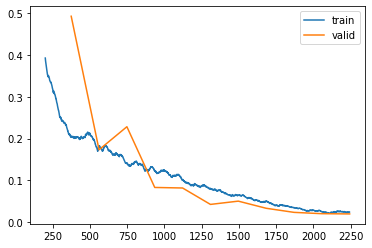

In [43]:
learn_34_unt.recorder.plot_loss(skip_start=200)

In [44]:
learn_34_unt.validate(dl=test_dl)

(#5) [0.017111217603087425,0.005499999970197678,0.9944999814033508,0.9945027227596519,0.994406523586257]

Without augmentation

| Metric | Value |
|--------|-----:|
| Error Rate | 0.005250
| Accuracy | 0.994750
| Precision | 0.994779
| Recall | 0.994746


With augmentation (12 epoch)

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00550000
| Accuracy | 0.99450000
| Precision | 0.99450272
| Recall | 0.99440652

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=9.12010818865383e-07)

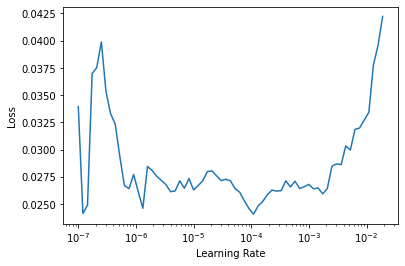

In [45]:
learn_34_unt.lr_find()

In [46]:
n = 12
lr = 1e-5
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.024273,0.020061,0.005750,0.994250,0.994243,0.994210,00:59
1,0.025166,0.020279,0.005583,0.994417,0.994420,0.994381,00:58
2,0.021255,0.019957,0.005417,0.994583,0.994610,0.994537,00:58
3,0.021536,0.019948,0.005583,0.994417,0.994429,0.994364,00:59
4,0.021343,0.019719,0.005417,0.994583,0.994616,0.994529,01:00
5,0.021068,0.020135,0.005750,0.994250,0.994273,0.994172,01:00
6,0.019715,0.020253,0.005833,0.994167,0.994194,0.994101,01:00
7,0.019934,0.020018,0.005500,0.994500,0.994531,0.994457,00:59
8,0.020861,0.020042,0.005667,0.994333,0.994375,0.994282,01:00
9,0.021095,0.020045,0.005500,0.994500,0.994536,0.994456,00:59


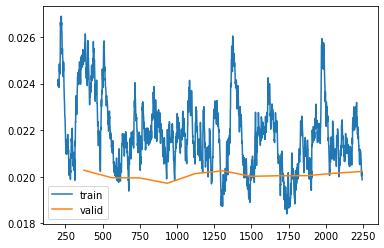

In [47]:
learn_34_unt.recorder.plot_loss(skip_start=200)

In [48]:
learn_34_unt.validate(dl=test_dl)

(#5) [0.01646798849105835,0.004999999888241291,0.9950000047683716,0.994989374590513,0.9949151000267291]

With augmentation (12 additional epochs)

| Metric | Value |
|--------|-----:|
| Error Rate | 0.00500000
| Accuracy | 0.99500000
| Precision | 0.99498937
| Recall | 0.99491510

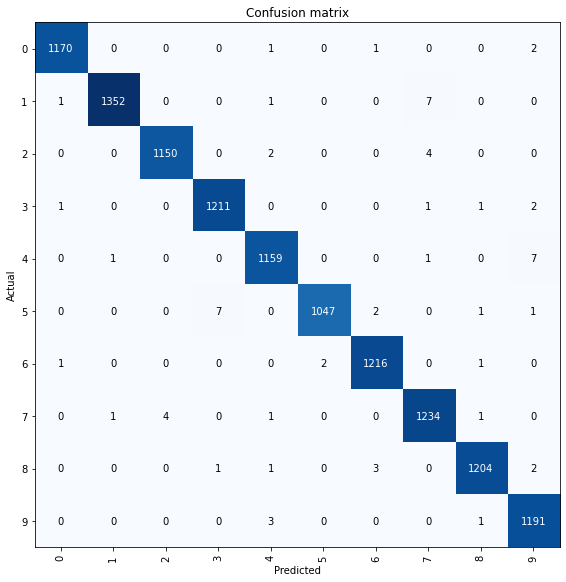

In [49]:
interp_34_unt = ClassificationInterpretation.from_learner(learn_34_unt)
interp_34_unt.plot_confusion_matrix(figsize=(8,8))

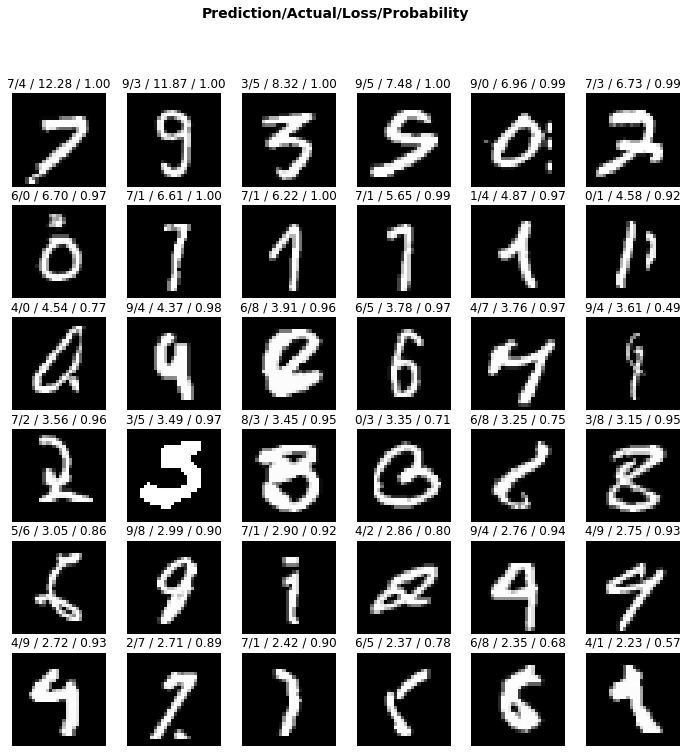

In [55]:
# interp_34_unt.most_confused()
interp_34_unt.plot_top_losses(k=36, figsize=(12,12))

## Resnet 34, augmentation, mixup and label smoothing

- `loss_funct=LabelSmoothingCrossEntropy()`
- `cbs=MixUp()`

In [61]:
learn_34_unt = cnn_learner(dls, 
                           resnet34, 
                           metrics=[error_rate, accuracy, precision, recall], 
                           loss_func=LabelSmoothingCrossEntropy(),
                           pretrained=False)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.013182567432522774)

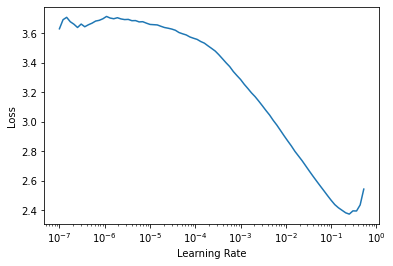

In [58]:
learn_34_unt.lr_find()

In [62]:
n = 18
lr = 5e-3
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.996890,0.694623,0.045667,0.954333,0.955231,0.953943,00:59
1,0.719282,0.672342,0.047750,0.952250,0.953402,0.952502,00:59
2,0.683418,0.642272,0.043667,0.956333,0.960488,0.955973,00:59
3,0.648781,1.398842,0.058417,0.941583,0.948166,0.941457,00:59
4,0.648934,0.551913,0.015833,0.984167,0.984123,0.984231,00:59
5,0.608063,0.665820,0.017917,0.982083,0.982536,0.982039,00:59
6,0.595501,0.560466,0.018833,0.981167,0.980839,0.981214,00:59
7,0.573963,0.537315,0.013750,0.986250,0.986190,0.986289,00:58
8,0.559434,0.537523,0.010750,0.989250,0.989261,0.989173,00:59
9,0.552290,0.529826,0.011583,0.988417,0.988502,0.988317,00:58


In [66]:
learn_34_unt = cnn_learner(dls, 
                           resnet34, 
                           metrics=[error_rate, accuracy, precision, recall], 
                           cbs=MixUp(),
                           pretrained=False)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.007585775572806597)

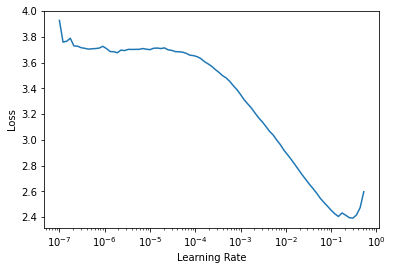

In [64]:
learn_34_unt.lr_find()

In [67]:
n = 60
lr = 5e-3
learn_34_unt.fit_one_cycle(n_epoch=n, lr_max=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.742799,0.168702,0.052917,0.947083,0.948056,0.947302,00:57
1,0.421168,0.232829,0.067750,0.932250,0.941907,0.930407,00:56
2,0.338233,0.694960,0.196167,0.803833,0.875774,0.810617,00:57
3,0.301920,0.130510,0.038417,0.961583,0.963323,0.961431,00:57
4,0.279985,0.244805,0.072000,0.928000,0.936541,0.928795,00:57
5,0.259933,0.142445,0.039167,0.960833,0.965072,0.960477,00:58
6,0.248657,1.990916,0.241917,0.758083,0.878661,0.759092,00:58
7,0.221167,0.095080,0.028333,0.971667,0.972841,0.971858,00:58
8,0.209215,0.065265,0.018250,0.981750,0.981870,0.981938,00:58
9,0.207008,0.091199,0.024333,0.975667,0.976512,0.975841,00:58


In [1]:
learn_34_unt.validate(dl=test_dl)

NameError: ignored